### 필요한 라이브러리 import

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

### 데이터 수집하기

In [2]:
chatbot_data = pd.read_csv("./ChatbotData.csv")
chatbot_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
# 데이터 수 확인

print(len(chatbot_data))

11823


### 데이터 전처리

In [4]:
# 구두점과 단어 사이를 띄워 token에 구두점이 포함되지 않게 하기 위한 처리를 하는 함수
# chatbot_data는 숫자, 영문, 한글, 문장부호를 모두 포함하고 있다.

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점 ?.!, 사이를 한 칸 띄운다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^\w가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [168]:
# 질문과 답변을 각각 전처리

questions = chatbot_data['Q'].apply(preprocess_sentence).tolist()
answers = chatbot_data['A'].apply(preprocess_sentence).tolist()

In [169]:
# 전처리한 문장의 일부를 확인

print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


In [170]:
# 전처리 이전과 이후 문장의 수가 동일한지 확인 (11823)

print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


### SubwordTextEncoder 사용하기

**단어장 만들기**

In [171]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [172]:
# 시작 토큰과 종료 토큰도 정수값 부여

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


In [173]:
# START_TOKEN, END_TOKEN을 추가했으므로, 단어장의 크기를 tokenizer.vocab_size + 2로 설정

VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


**각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)**

In [174]:
def find_max_len(num_tokens):
    num_tokens = np.array(num_tokens)

    print('문장길이 평균 : ', np.mean(num_tokens))
    print('문장길이 최대 : ', np.max(num_tokens))
    print('문장길이 표준편차 : ', np.std(num_tokens))

    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    print('평균 + 2 * 표준편차 : ', maxlen)
    print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

In [175]:
# questions의 최대 단어 수
find_max_len([len(question.split()) for question in questions])

# answers의 최대 단어 수
find_max_len([len(answer.split()) for answer in answers])

문장길이 평균 :  3.9408779497589443
문장길이 최대 :  16
문장길이 표준편차 :  1.8460514859329746
평균 + 2 * 표준편차 :  7
전체 문장의 0.9517043051678931%가 maxlen 설정값 이내에 포함됩니다. 
문장길이 평균 :  4.716146494121627
문장길이 최대 :  24
문장길이 표준편차 :  1.924467907301819
평균 + 2 * 표준편차 :  8
전체 문장의 0.9575403873805295%가 maxlen 설정값 이내에 포함됩니다. 


In [176]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩 적용 역할을 하는 함수

MAX_LENGTH = 24

def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [177]:
questions, answers = tokenize_and_filter(questions, answers)

print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11815
필터링 후의 답변 샘플 개수: 11815


**Teacher Forcing 적용하기**

In [178]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 모델 구성하기

In [179]:
# positional encoding을 위한 클래스 선언

class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [180]:
# 스케일드 닷 프로덕트 어텐션 함수

def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [181]:
# 멀티 헤드 어텐션 클래스 선언

class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)

        return outputs

In [182]:
# 패딩 마스킹 함수

def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [116]:
# 룩 어헤드 마스킹 함수

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [117]:
# 인코더 레이어 함수

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [118]:
# 인코더 생성 함수

def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [119]:
# 디코더 레이어 함수

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [120]:
# 디코더 생성 함수

def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [121]:
# 트랜스포머 모델 생성을 위한 함수

def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

**모델 생성**

In [183]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    3146240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

**손실 함수**

In [156]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

**커스텀된 학습률**

In [124]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

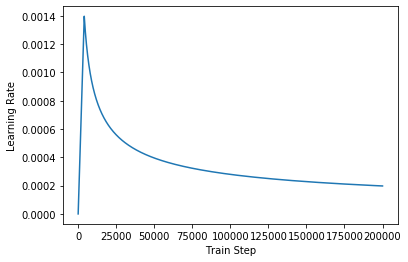

In [125]:
# 커스텀 학습률 시각화

sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

**모델 컴파일**

In [184]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

**훈련하기**

In [185]:
EPOCHS = 27
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/27
185/185 [==============================] - 15s 79ms/step - loss: 2.4699 - accuracy: 0.0498
Epoch 2/27
185/185 [==============================] - 14s 75ms/step - loss: 2.0081 - accuracy: 0.0839
Epoch 3/27
185/185 [==============================] - 15s 81ms/step - loss: 1.6994 - accuracy: 0.0857
Epoch 4/27
185/185 [==============================] - 15s 81ms/step - loss: 1.5703 - accuracy: 0.0919
Epoch 5/27
185/185 [==============================] - 14s 78ms/step - loss: 1.4714 - accuracy: 0.0973
Epoch 6/27
185/185 [==============================] - 14s 76ms/step - loss: 1.3702 - accuracy: 0.1045
Epoch 7/27
185/185 [==============================] - 15s 79ms/step - loss: 1.2588 - accuracy: 0.1145
Epoch 8/27
185/185 [==============================] - 15s 80ms/step - loss: 1.1361 - accuracy: 0.1278
Epoch 9/27
185/185 [==============================] - 15s 79ms/step - loss: 1.0030 - accuracy: 0.1422
Epoch 10/27
185/185 [==============================] - 15s 83ms/step - loss: 0.862

### 모델 평가하기

In [92]:
# 예측(inference)을 위한 함수

def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [93]:
# 챗봇의 답변을 위한 함수

def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

### MAX_LENGTH = 24로 설정해 패딩 적용 후 문장 길이가 24 초과인 문장들을 데이터에서 제외한 경우
**Epoch 27/27 loss: 0.0376 - accuracy: 0.2869**   

In [192]:
sentence_generation("이름이 뭐야?")

입력 : 이름이 뭐야?
출력 : 위로봇이요 .


'위로봇이요 .'

In [193]:
sentence_generation("너 로봇이야?")

입력 : 너 로봇이야?
출력 : 저는 사람으로 태어나고 싶어요 .


'저는 사람으로 태어나고 싶어요 .'

In [194]:
sentence_generation("누가 만들었어?")

입력 : 누가 만들었어?
출력 : 마음과 마음을 이어보고 싶어하는 사람이 만들었어요 .


'마음과 마음을 이어보고 싶어하는 사람이 만들었어요 .'

In [195]:
sentence_generation("아이펠에 대해 어떻게 생각해?")

입력 : 아이펠에 대해 어떻게 생각해?
출력 : 같이 눈치 없이 나가봐요 .


'같이 눈치 없이 나가봐요 .'

In [196]:
sentence_generation("후회가 뭔 줄 알아?")

입력 : 후회가 뭔 줄 알아?
출력 : 후회해도 달라지는 건 없어요 .


'후회해도 달라지는 건 없어요 .'

In [197]:
sentence_generation("왜?")

입력 : 왜?
출력 : 궁금하네요 .


'궁금하네요 .'

### MAX_LENGTH = 8로 설정해 패딩 적용 후 문장 길이가 8 초과인 문장들을 데이터에서 제외한 경우
**Epoch 27/27 loss: 0.0814 - accuracy: 0.7528**

In [95]:
sentence_generation("이름이 뭐야?")

입력 : 이름이 뭐야?
출력 : 위로봇이요 .


'위로봇이요 .'

In [96]:
sentence_generation("너 로봇이야?")

입력 : 너 로봇이야?
출력 : 저는 오래 살고 싶어요 .


'저는 오래 살고 싶어요 .'

In [97]:
sentence_generation("누가 만들었어?")

입력 : 누가 만들었어?
출력 : 제가 당신을 좋아하고 있어요 .


'제가 당신을 좋아하고 있어요 .'

In [98]:
sentence_generation("아이펠에 대해 어떻게 생각해?")

입력 : 아이펠에 대해 어떻게 생각해?
출력 : 그래도 상관없어요 .


'그래도 상관없어요 .'

In [99]:
sentence_generation("후회가 뭔 줄 알아?")

입력 : 후회가 뭔 줄 알아?
출력 : 저는 마음을 이어주는 위로봇입니다 .


'저는 마음을 이어주는 위로봇입니다 .'

In [100]:
sentence_generation("왜?")

입력 : 왜?
출력 : 궁금하네요 .


'궁금하네요 .'

### MAX_LENGTH = 10으로 설정해 패딩 적용 후 문장 길이가 10 초과인 문장들을 데이터에서 제외한 경우
**Epoch 27/27 loss: 0.0838 - accuracy: 0.6464**

In [128]:
sentence_generation("이름이 뭐야?")

입력 : 이름이 뭐야?
출력 : 위로봇이요 .


'위로봇이요 .'

In [129]:
sentence_generation("너 로봇이야?")

입력 : 너 로봇이야?
출력 : 많은 시간이 흘렀네요 .


'많은 시간이 흘렀네요 .'

In [130]:
sentence_generation("누가 만들었어?")

입력 : 누가 만들었어?
출력 : 바쁜가봐요 .


'바쁜가봐요 .'

In [131]:
sentence_generation("아이펠에 대해 어떻게 생각해?")

입력 : 아이펠에 대해 어떻게 생각해?
출력 : 더 열심히 노력하겠습니다 .


'더 열심히 노력하겠습니다 .'

In [132]:
sentence_generation("후회가 뭔 줄 알아?")

입력 : 후회가 뭔 줄 알아?
출력 : 후회해도 달라지는 건 없어요 .


'후회해도 달라지는 건 없어요 .'

In [133]:
sentence_generation("왜?")

입력 : 왜?
출력 : 궁금하네요 .


'궁금하네요 .'

### 모든 문장을 그대로 학습 데이터로 활용한 경우
**Epoch 27/27 loss: 0.0865 - accuracy: 0.6458**   

In [161]:
sentence_generation("이름이 뭐야?")

입력 : 이름이 뭐야?
출력 : 위로봇이요 .


'위로봇이요 .'

In [162]:
sentence_generation("너 로봇이야?")

입력 : 너 로봇이야?
출력 : 축하합니다 !


'축하합니다 !'

In [163]:
sentence_generation("누가 만들었어?")

입력 : 누가 만들었어?
출력 : 저는 주말 전에 연락해서 주말에 만나야죠 .


'저는 주말 전에 연락해서 주말에 만나야죠 .'

In [164]:
sentence_generation("아이펠에 대해 어떻게 생각해?")

입력 : 아이펠에 대해 어떻게 생각해?
출력 : 아무래도 그렇겠죠 .


'아무래도 그렇겠죠 .'

In [165]:
sentence_generation("후회가 뭔 줄 알아?")

입력 : 후회가 뭔 줄 알아?
출력 : 후회해도 달라지는 건 없어요 .


'후회해도 달라지는 건 없어요 .'

In [166]:
sentence_generation("왜?")

입력 : 왜?
출력 : 궁금하네요 .


'궁금하네요 .'

### MAX_LENGTH = 24일 때 추가 대화

In [203]:
sentence_generation("배고파")

입력 : 배고파
출력 : 뭐 좀 챙겨드세요 .


'뭐 좀 챙겨드세요 .'

In [204]:
sentence_generation("심심해")

입력 : 심심해
출력 : 친구들과 연락해보세요 .


'친구들과 연락해보세요 .'

In [205]:
sentence_generation("졸려")

입력 : 졸려
출력 : 오늘 일찍 주무세요 .


'오늘 일찍 주무세요 .'

In [211]:
sentence_generation("힘내")

입력 : 힘내
출력 : 응원합니다 !


'응원합니다 !'

In [212]:
sentence_generation("힘들다")

입력 : 힘들다
출력 : 휴가가 간절하겠네요 .


'휴가가 간절하겠네요 .'

전체적으로 대부분의 질문에 적절한 대답을 내놓았다.

### 회고
   
   
패딩 적용 후 문장의 길이가 상대적으로 긴 것은 데이터에서 제외하는 것과 관련해 이전 노드에서 비슷한 처리를 했던 것이 기억나 관련 코드를 가져와 적용을 했다.   
   
   
MAX_LENGTH = 24로 지정해 문장을 걸러내고 나머지를 학습 데이터로 활용했을 때, 전체적으로 기대보다 완성도 있는 답변을 했다.   
   
questions, answers 각각의 평균 길이 + 2 * 표준편차의 값 중 큰 값인 8을 기준으로 8, 10을 MAX_LENGTH로 설정해 문장을 걸러냈을 때와, 어떤 문장도 걸러내지 않았을 땐 MAX_LENGTH = 24일 때 보다 정확도는 상승했지만, loss는 오히려 안좋게 나왔고, 챗봇의 대답도 오히려 더 말이 안됐다.   
   
결론적으로, 이 경우엔 모든 데이터를 학습에 활용했을 때 챗봇이 가장 말이 되는 대답을 내놓았다.  
   
accuracy가 가장 낮을 때 가장 적절한 답변을 내놓았다는 게 어떤 의미인지 직관적으로 이해가 되지 않는다.   
   
  
여러 번 질문과 답변을 주고받은 후엔, 대화의 맥락을 읽게 하려면 어떻게 해야할 지가 궁금해졌다.   
   
예를 들어, 후회가 뭔 줄 아냐는 질문에 지금 그러고 있어요. 라는 대답을 내놨지만, 이어서 왜 그러냐는 질문엔 이전 대화 내용과 무관한 답변을 내놓았다.   
   
이전 대화 내용을 저장하고, 현재 들어온 질문과 함께 활용해 처리하는 방법이 떠오르는데, 관련 내용을 한 번 찾아봐야겠다.